# Data Preparation

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd

all_games_df = pd.read_csv("data/all_games.csv",encoding="utf-8")
all_games_df.drop("Unnamed: 0", axis=1,inplace=True)

# Data Preparation

In [ ]:
from api_helpers.game_stats_helpers import load_past_n_games
columns = ["FG_PCT", "FG3_PCT", "FTM", "OREB", "DREB", "REB", "AST"]
columns_a = [column + "_A" for column in columns]
columns_b = [column + "_B" for column in columns]

n_games_df = load_past_n_games(all_games_df=all_games_df, columns=columns)
n_games_df = n_games_df.dropna()

In [ ]:
merged_data = pd.merge(
    all_games_df[columns_a + columns_b], n_games_df, left_index=True, right_index=True
)


columns_x = columns_a + columns_b
columns_x = [column + "_x" for column in columns_x]
X = merged_data[columns_x]

In [ ]:
columns_y = columns_a + columns_b
columns_y = [column + "_y" for column in columns_y]
y = merged_data[columns_y]

## Test Train Split

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

NameError: name 'X' is not defined

# Preloading Neural Network

In [ ]:
# Predicting Game Outcome
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open("tuned_nn.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("tuned.weights.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

2024-07-22 14:21:54.040622: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 14:21:54.052357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 14:21:54.062397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 14:21:54.065192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 14:21:54.072864: I tensorflow/core/platform/cpu_feature_guar

Loaded model from disk


2024-07-22 14:21:54.834515: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-07-22 14:21:54.834537: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: rohanbendapudi-Precision-3581
2024-07-22 14:21:54.834540: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: rohanbendapudi-Precision-3581
2024-07-22 14:21:54.834651: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 535.183.1
2024-07-22 14:21:54.834659: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 535.183.1
2024-07-22 14:21:54.834661: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 535.183.1


In [ ]:
y_final_true = all_games_df["WL_A"].loc[y_test.index].to_frame()
y_final_true.replace("W",1,inplace=True)
y_final_true.replace("L",0,inplace=True)
y_final_true.replace(" ",0,inplace=True)
y_final_true = list(y_final_true["WL_A"])

/tmp/ipykernel_446751/583459057.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_final_true.replace("L",0,inplace=True)


# Building and Testing XGBoost

In [ ]:
%skip
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

UsageError: Line magic function `%skip` not found.


In [ ]:
%skip
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

UsageError: Line magic function `%skip` not found.


## Hyperparameter Tuning

In [ ]:
%skip
from hyperopt import tpe, hp, STATUS_OK
from sklearn.metrics import r2_score, mean_squared_error
import hyperopt
import sklearn
import optuna
from xgboost import XGBRegressor

def objective(trial):
    # param = {
    #     "device": "cuda",
    #     "gamma": trial.suggest_categorical("gamma", [18, 19, 20, 21, 22, 23, 24, 25]),
    #     "learning_rate": trial.suggest_categorical(
    #         "learning_rate", [0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]
    #     ),
    #     "colsample_bytree": trial.suggest_categorical(
    #         "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #     ),
    #     "colsample_bynode": trial.suggest_categorical(
    #         "colsample_bynode", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #     ),
    #     "n_estimators": trial.suggest_int("n_estimators", 30, 200),
    #     "max_depth": trial.suggest_categorical("max_depth", [3, 4, 5, 6, 7]),
    #     "subsample": trial.suggest_categorical("subsample", [0.5, 0.6, 0.7, 0.8, 1.0]),
    #     "random_state": 42,
    # }

    param = {
        "device": "cuda",
        "n_estimators": 100,
        "max_depth": 8,
        "eta": 0.1,
        "subsample": 0.4,
        "colsample_bytree": 0.9,
        "random_state": 42,
        "gamma": trial.suggest_categorical("gamma", [0, 1, 2, 3, 4, 5]),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.1, 0.2, 0.3, 0.4, 0.5]
        ),
        "colsample_bynode": trial.suggest_categorical(
            "colsample_bynode", [0.3, 0.4, 0.5, 0.6, 0.7]
        ),
    }

    model = XGBRegressor(**param)

    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict(X_test)

    scaler = joblib.load("scaler.bin")

    y_final_pred = loaded_model.predict(scaler.transform(y_pred))
    y_pred_true = np.argmax(y_final_pred, axis=1)

    y_pred_true = y_pred_true.tolist()

    accuracy = accuracy_score(y_final_true, list(y_pred_true))

    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=600)

UsageError: Line magic function `%skip` not found.


In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  3
Best trial:
  Value: 0.6014581952466622
  Params: 


/home/rohanbendapudi/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:22:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
<class 'int'>
True
Best Neural Network classification report:
              precision    recall  f1-score   support

           0       0.78      0.24      0.37      4206
           1       0.66      0.96      0.78      6355

    accuracy                           0.67     10561
   macro avg       0.72      0.60      0.57     10561
weighted avg       0.71      0.67      0.62     10561



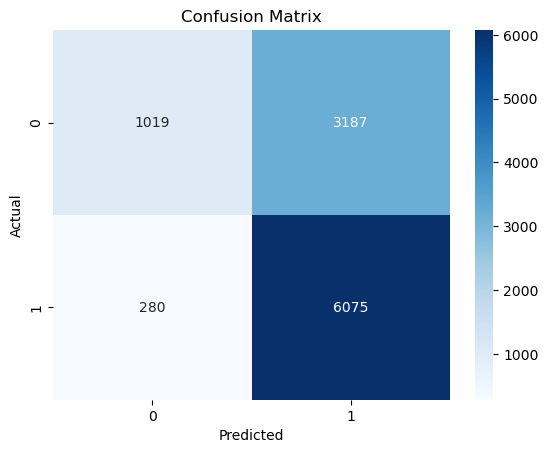

In [ ]:

from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# create an xgboost regression model

param = {
    "device": "cuda",
    "n_estimators": 100,
    "max_depth": 8,
    "eta": 0.1,
    "subsample": 0.4,
    "colsample_bytree": 0.9,
    "random_state": 42,
    "gamma": 0,
    "learning_rate":0.1,
    "colsample_bynode": 0.6,
}

model = XGBRegressor(**param)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

scaler = joblib.load("scaler.bin")

y_final_pred = loaded_model.predict(scaler.transform(y_pred))
y_pred_true = np.argmax(y_final_pred, axis=1)

y_pred_true = y_pred_true.tolist()
print(type(y_pred_true[0]))

print(all(isinstance(x, int) for x in y_final_true))

# Evaluate the model
print('Best Neural Network classification report:')
print(classification_report(y_final_true, list(y_pred_true)))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_final_true, list(y_pred_true))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import shap
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation

In [ ]:
X_idx = 0
shap_value_single = explainer.shap_values(X=X.iloc[X_idx : X_idx + 1, :])

In [ ]:
import ipywidgets as widgets

# Create the list of all labels for the drop down list
list_of_labels = y.columns.to_list()

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels, value=0, description="Select Label:")

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

Dropdown(description='Select Label:', options=(('FG_PCT_A_y', 0), ('FG3_PCT_A_y', 1), ('FTM_A_y', 2), ('OREB_A…

In [1]:
import pandas as pd

all_games_df = pd.read_csv("data/all_games.csv")

In [2]:
output_a_features = [
    "FG_PCT_A",
    "FG3_PCT_A",
    "FTM_A",
    "OREB_A",
    "DREB_A",
    "REB_A",
    "AST_A",
]
output_b_features = [word.replace("_A", "_B") for word in output_a_features]
output_features = output_a_features + output_b_features

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

import tensorflow as tf

recorded_games = all_games_df[all_games_df["WL_A"] != " "]

X_input = np.asarray(recorded_games[output_features])
y_output = recorded_games["WL_A"]


y_output.replace("L", 0, inplace=True)
y_output.replace("W", 1, inplace=True)

X_input = np.asarray(X_input).astype(np.float32)
y_output = np.asarray(y_output).astype(np.int32)

recorded_games[output_features + ["WL_A"]]
recorded_games[(recorded_games["WL_A"] == 0.0) | (recorded_games["WL_A"] == 1.0)]

2024-07-26 13:48:34.658811: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-26 13:48:34.665263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 13:48:34.672295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 13:48:34.674297: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 13:48:34.679697: I tensorflow/core/platform/cpu_feature_guar

,Unnamed: 0,SEASON_ID,TEAM_ID_A,TEAM_ABBREVIATION_A,TEAM_NAME_A,GAME_ID,GAME_DATE,MATCHUP_A,WL_A,MIN_A,...,FT_PCT_B,OREB_B,DREB_B,REB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B,PLUS_MINUS_B
0,7,22023,1610612737,ATL,Atlanta Hawks,22301159,2024-04-10,ATL vs. CHA,0.0,240,...,0.955,5.0,28.0,33.0,25,11.0,2,13,18,1.0
1,9,22023,1610612737,ATL,Atlanta Hawks,22301147,2024-04-09,ATL vs. MIA,0.0,292,...,0.714,5.0,41.0,46.0,29,8.0,3,18,16,6.0
2,15,22023,1610612737,ATL,Atlanta Hawks,22301104,2024-04-03,ATL vs. DET,1.0,240,...,0.810,8.0,29.0,37.0,24,14.0,3,10,13,-8.0
3,19,22023,1610612737,ATL,Atlanta Hawks,22301076,2024-03-30,ATL vs. MIL,0.0,239,...,0.800,6.0,34.0,40.0,27,7.0,5,10,18,9.0
4,21,22023,1610612737,ATL,Atlanta Hawks,22301060,2024-03-28,ATL vs. BOS,1.0,265,...,0.857,9.0,34.0,43.0,28,7.0,6,12,15,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52802,211440,21988,1610612766,CHH,Charlotte Hornets,28800140,1988-11-26,CHH vs. WAS,0.0,220,...,0.788,14.0,28.0,42.0,25,7.0,1,17,25,NaN
52803,211446,21988,1610612766,CHH,Charlotte Hornets,28800115,1988-11-22,CHH vs. DET,0.0,240,...,0.920,15.0,34.0,49.0,18,4.0,5,17,15,NaN
52804,211452,21988,1610612766,CHH,Charlotte Hornets,28800071,1988-11-15,CHH vs. NJN,0.0,240,...,0.519,16.0,30.0,46.0,22,9.0,5,19,24,NaN
52805,211458,21988,1610612766,CHH,Charlotte Hornets,28800024,1988-11-08,CHH vs. LAC,1.0,240,...,0.564,13.0,35.0,48.0,21,8.0,6,20,34,NaN


In [4]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# y_cleaned = y_output[~np.isnan(X_input)]
# X_cleaned = X_input[all(~np.isnan(X_input))]
X_truth = ~np.isnan(X_input).any(axis=1)
y_truth = (y_output == 0) | (y_output == 1)
y_cleaned = y_output[X_truth & y_truth]
X_cleaned = X_input[X_truth & y_truth]

In [5]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned, test_size=0.2, random_state=3
)



# Scaling Data

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import joblib
import sys
from joblib import dump
import pickle
from sklearn.preprocessing import StandardScaler



scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
X_train

# Assuming `scaler` is your fitted StandardScaler instance
with open('scaler.bin', 'wb') as f:
    pickle.dump(scaler, f)


In [7]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

# Without Tuning

In [8]:
%%skip
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_proba = model.predict(x=X_test)

# print(y_pred_proba)

# y_pred = np.argmax(y_pred_proba)
# # y_test_true = np.argmax(y_test)

# # print(y_test_true)
# custom_threshold = 0.5
# y_pred_proba = (y_pred_proba >= custom_threshold).astype(int)

# print(y_pred_proba)


# Evaluate the model
print("Best Neural Network classification report:")
print(classification_report(y_test, y_pred_proba))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_test, y_pred_proba)
sns.heatmap(conf_matrix_nn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

UsageError: Cell magic `%%skip` not found.


# With Tuning

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [10]:
import keras_tuner as kt
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow import keras

def model_builder(hp):
    model = Sequential()

    hp_units = hp.Int("units", min_value=16, max_value=128, step=32)

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    activations = hp.Choice("activation", values=["relu", "tanh"])
    final_activation = hp.Choice("activation", values=["sigmoid", "softmax"])

    model.add(keras.Input(shape=(14,)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float("dropout", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp_units, activation=activations))
    model.add(Dropout(hp.Float("dropout", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp_units, activation=activations))
    model.add(Dropout(hp.Float("dropout", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(2, activation="sigmoid"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model




tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_epochs=10,
    factor=3,
    directory="my_dir",
    project_name="third",
)

print(tuner)

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

tuner.search(X_train, y_train, epochs=5,
             validation_split=0.2, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

print(best_hps)

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
"""
)

Trial 30 Complete [00h 00m 14s]
val_accuracy: 0.8839426040649414

Best val_accuracy So Far: 0.9060200452804565
Total elapsed time: 00h 02m 36s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 48 and the optimal learning rate for the optimizer
is 0.001.



In [11]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# results = model.fit(X_train, y_train, epochs=50, validation_split=0.2)
results = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])


Epoch 1/50


1037/1037 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8633 - loss: 0.3135 - val_accuracy: 0.8997 - val_loss: 0.2350
Epoch 2/50
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8816 - loss: 0.2729 - val_accuracy: 0.9018 - val_loss: 0.2292
Epoch 3/50
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8858 - loss: 0.2619 - val_accuracy: 0.9014 - val_loss: 0.2253
Epoch 4/50
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8862 - loss: 0.2616 - val_accuracy: 0.9022 - val_loss: 0.2305
Epoch 5/50
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.8834 - loss: 0.2673 - val_accuracy: 0.9016 - val_loss: 0.2282
Epoch 6/50
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - accuracy: 0.8886 - loss: 0.2569 - val_accuracy: 0.9057 - val_loss: 0.2267
Epoch 7/50
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.8846 - loss: 0.2634 - val_accuracy: 0.9042 - val_loss: 0.2253
Epoch 8/50
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8850 - loss: 0.2670 - val_a

Best epoch: 15
Best Neural Network accuracy: 90.67%
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
Best epoch: 15
Best Neural Network accuracy: 90.67%
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step
Best Neural Network classification report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4110
           1       0.93      0.91      0.92      6251

    accuracy                           0.91     10361
   macro avg       0.90      0.90      0.90     10361
weighted avg       0.91      0.91      0.91     10361



<Axes: >

Text(0.5, 23.52222222222222, 'Predicted')

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix')

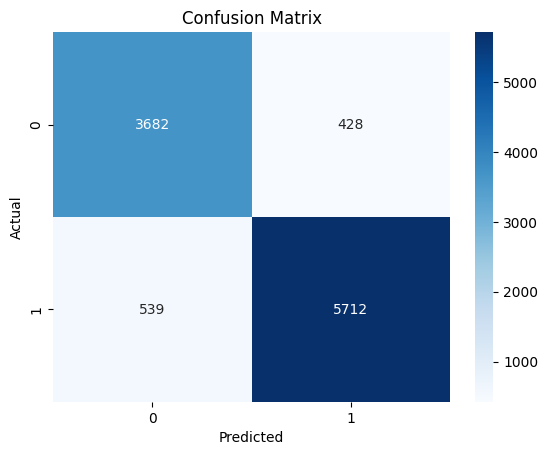

Best Neural Network classification report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4110
           1       0.93      0.91      0.92      6251

    accuracy                           0.91     10361
   macro avg       0.90      0.90      0.90     10361
weighted avg       0.91      0.91      0.91     10361



<Axes: >

Text(0.5, 23.52222222222222, 'Predicted')

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix')

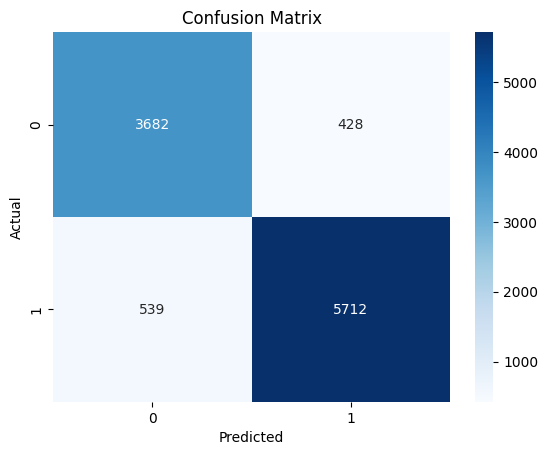

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

val_acc_per_epoch = results.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Best Neural Network accuracy: {accuracy * 100:.2f}%")

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Evaluate the modelimport numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

val_acc_per_epoch = results.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Best Neural Network accuracy: {accuracy * 100:.2f}%")

# Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Evaluate the model
print('Best Neural Network classification report:')
print(classification_report(y_test_true, y_pred))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_test_true, y_pred)
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print('Best Neural Network classification report:')
print(classification_report(y_test_true, y_pred))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_test_true, y_pred)
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Text(0.5, 1.0, 'Model accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

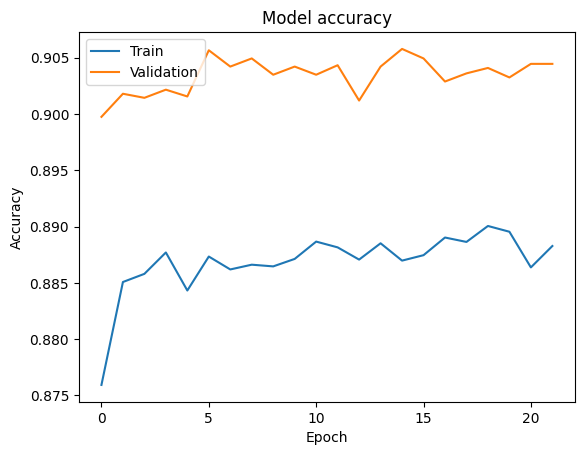

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

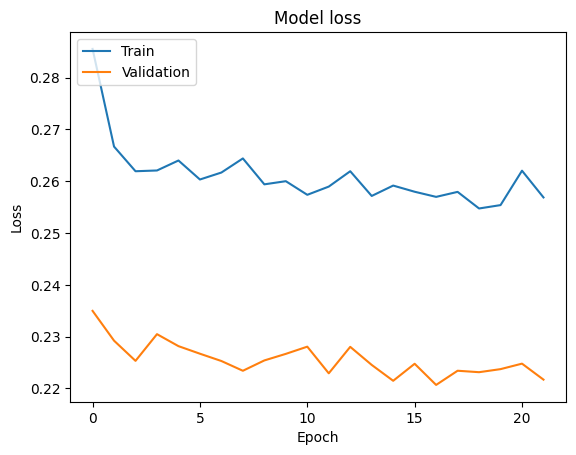

In [13]:
# history = model.fit(X_train, y_train, epochs=70, validation_split=0.2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
json_model = model.to_json()
with open("tuned_nn.json", "w") as json_file:
    json_file.write(json_model)
# serialize weights to HDF5
model.save_weights("tuned.weights.h5")
print("Saved model to disk")

5275

Saved model to disk


In [15]:
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open("tuned_nn.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("tuned.weights.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

Loaded model from disk


In [16]:
# print(loaded_model.predict(X_test[0]))
# print(len(X_test))
X_test[0]

array([-0.12796563, -0.37922123, -1.7140071 , -1.3632866 ,  1.356431  ,
        0.2401674 ,  0.41703546,  0.72311115, -0.53644377,  0.6887569 ,
       -1.0903503 ,  2.63344   ,  1.5322409 ,  1.3005766 ], dtype=float32)

In [27]:
X_train = pd.DataFrame(X_train, columns=output_features)
y_train = pd.DataFrame(y_train.iloc[:, 0])
X_test = pd.DataFrame(X_test, columns=output_features)
y_test = pd.DataFrame(y_test.iloc[:,0])

In [30]:
X_train.to_csv("X_train.csv")
y_train.to_csv("y_train.csv")
X_test.to_csv("X_test.csv")
y_test.to_csv("y_test.csv")

In [33]:
y_train

,0
0,1.0
1,1.0
2,0.0
3,1.0
4,0.0
...,...
41437,0.0
41438,0.0
41439,1.0
41440,0.0
